# Look at different country data GDP, military spending etc,

We have found two data sets one from Kaggle about military spending per country for the last 60 years, and then a general set of data about each country (population, surface area etc).  Lets focus on what we can get out of the military spending data, using the other more general data as a way to generate some more interesting features

Ideas for questions to answer:
1. Look at the usual comparisons, relating GDP, GNI to military spending.
2. Is there anything significant about when countries start military spending?
2. Can we find any dramatic changes in military spending of any country and relate it to a real world event?
3. Compare Foreign direct investment to military spending

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry_convert as pc
import pycountry
%matplotlib inline

In [2]:
ms_df = pd.read_csv('Military Expenditure.csv')
wb_df = pd.read_csv('popular_indicators.csv')

Lets have a look at the data

In [3]:
ms_df.head()

,Name,Code,Type,Indicator Name,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Aruba,ABW,Country,Military expenditure (current USD),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,Country,Military expenditure (current USD),NaN,NaN,NaN,NaN,NaN,NaN,...,2.518695e+08,2.981469e+08,3.258070e+08,2.385834e+08,2.171941e+08,2.682271e+08,1.995186e+08,1.858783e+08,1.914071e+08,1.980863e+08
2,Angola,AGO,Country,Military expenditure (current USD),NaN,NaN,NaN,NaN,NaN,NaN,...,3.311193e+09,3.500795e+09,3.639496e+09,4.144635e+09,6.090752e+09,6.841864e+09,3.608299e+09,2.764055e+09,3.062873e+09,1.983614e+09
3,Albania,ALB,Country,Military expenditure (current USD),NaN,NaN,NaN,NaN,NaN,NaN,...,1.827369e+08,1.858932e+08,1.970068e+08,1.832047e+08,1.800155e+08,1.781204e+08,1.323507e+08,1.308532e+08,1.443827e+08,1.804887e+08
4,Andorra,AND,Country,Military expenditure (current USD),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ms_df['Type'].unique()

array(['Country', 'Regions Clubbed Geographically',
       'Semi Autonomous Region', 'Regions Clubbed Economically'],
      dtype=object)

In [5]:
ms_df.loc[ms_df['Type'].isin(['Regions Clubbed Geographically', 'Regions Clubbed Economically',
                             'Semi Autonomous Region'])]['Name'].unique()

array(['Arab World', 'American Samoa', 'Central Europe and the Baltics',
       'Channel Islands', 'Caribbean small states', 'Cayman Islands',
       'East Asia & Pacific (excluding high income)',
       'Early-demographic dividend', 'East Asia & Pacific',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia', 'Euro area', 'European Union',
       'Fragile and conflict affected situations', 'Faroe Islands',
       'High income', 'Hong Kong ',
       'Heavily indebted poor countries (HIPC)', 'IBRD only',
       'IDA & IBRD total', 'IDA total', 'IDA blend', 'IDA only',
       'Isle of Man', 'Not classified',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & Caribbean',
       'Least developed countries: UN classification', 'Low income',
       'Lower middle income', 'Low & middle income',
       'Late-demographic dividend', 'Macao ', 'St. Martin (French part)',
       'Middle East & North Africa', 'Marshall Islands', 'Mid

We have rows for few different collection of countries, these are not especially useful at the moment as it isn't clear which countries make up these regions.  We will drop these but maybe add in some of the detail later (e.g. continents) as a feature in each column.  

We are adding continents back  in further down, there are some codes which are difficult to map to a continent, so have been removed also.  None of the countries are significant for now

In [6]:
ms_df = ms_df[ms_df['Type']=='Country']
ms_df = ms_df[~ms_df['Code'].isin(['PSS','TLS'])]

In [53]:
ms_df = ms_df.fillna(0)

Lets have a look at the world bank dataframe

In [54]:
wb_df.head()

,Series Name,Series Code,Country Name,Country Code,1970,1971,1972,1973,1974,1975,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"Population, total",SP.POP.TOTL,Afghanistan,AFG,11173642,11475445,11791215,12108963,12412950,12689160,...,29185507,30117413,31161376,32269589,33370794,34413603,35383128,36296400,37172386,..
1,"Population, total",SP.POP.TOTL,Albania,ALB,2135479,2187853,2243126,2296752,2350124,2404831,...,2913021,2905195,2900401,2895092,2889104,2880703,2876101,2873457,2866376,..
2,"Population, total",SP.POP.TOTL,Algeria,DZA,14464985,14872250,15285990,15709825,16149025,16607707,...,35977455,36661444,37383887,38140132,38923687,39728025,40551404,41389198,42228429,..
3,"Population, total",SP.POP.TOTL,American Samoa,ASM,27363,27984,28567,29100,29596,30052,...,56079,55759,55667,55713,55791,55812,55741,55620,55465,..
4,"Population, total",SP.POP.TOTL,Andorra,AND,24276,25559,26892,28232,29520,30705,...,84449,83747,82427,80774,79213,78011,77297,77001,77006,..


Lets tidy up those column names to match the other dataframe

In [55]:
column_names = {col:col[:4]  for col in wb_df.columns if col[:4].isdigit()}
wb_df.rename(column_names, axis=1, inplace=True)

Lots of different statistics to look at, but not in a particularly useful format

In [56]:
wb_df['Series Name'].unique()

array(['Population, total', 'Population growth (annual %)',
       'Surface area (sq. km)',
       'Poverty headcount ratio at national poverty lines (% of population)',
       'GNI, Atlas method (current US$)',
       'GNI per capita, Atlas method (current US$)',
       'GNI, PPP (current international $)',
       'GNI per capita, PPP (current international $)',
       'Income share held by lowest 20%',
       'Life expectancy at birth, total (years)',
       'Fertility rate, total (births per woman)',
       'Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Contraceptive prevalence, any methods (% of women ages 15-49)',
       'Births attended by skilled health staff (% of total)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Prevalence of underweight, weight for age (% of children under 5)',
       'Immunization, measles (% of children ages 12-23 months)',
       'Primary completion rate, total (% of relevant age group)',
       'School en

Replace .. in wb dataframe with NaN. And rename columns to match other df

In [159]:
wb_df = wb_df.replace('..', None)
wb_df.rename({'Series Name':'Indicator Name','Country Code': 'Code','Country Name':'Name'},
              axis=1, inplace=True)

To match up the years drop the data before 1970 on military spending

In [161]:
ms_df.drop(list(ms_df.filter(regex='196.')),axis=1, inplace=True)

## Data wraggling and initial exploration

Get the continent for each country

In [162]:
def continent_from_country_code(row):
    """Returns the continent a country is a part of 
    from its 2 or 3 letter country code
    
    row - Dataframe row"""
    
    cc = row['Code']
    try:
        if len(cc) == 2:
            continent_code =  pc.country_alpha2_to_continent_code(cc)
        elif len(cc) == 3:
            cc2 = pycountry.countries.get(alpha_3=cc).alpha_2
            continent_code = pc.country_alpha2_to_continent_code(cc2)
    except AttributeError:
        # some of the codes in the database can't be found so we will do a fuzzy search as a back up
        try:
            fuz_search = pycountry.countries.search_fuzzy(row['Name'])[0].alpha_2
        except KeyError:
            fuz_search = pycountry.countries.search_fuzzy(row.index[0])[0].alpha_2
        continent_code = pc.country_alpha2_to_continent_code(fuz_search)
    
    continent_dict = {'NA':'North America', 'EU': 'Europe','AS':'Asia',
                     'AF':'Africa', 'SA':'South America','OC':'Oceania'}
    return continent_dict[continent_code]

In [212]:
ms_df['continent'] = ms_df.apply(continent_from_country_code, axis=1)


In [67]:
ms_df.head()

,Code,Type,Indicator Name,1970,1971,1972,1973,1974,1975,1976,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,continent
Name,,,,,,,,,,,,,,,,,,,,,
Aruba,ABW,Country,Military expenditure (current USD),0.000,0.0,0.0,0.000,0.000,0.000,0.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,North America
Afghanistan,AFG,Country,Military expenditure (current USD),2939585.501,0.0,0.0,3341271.551,3581366.351,4203664.569,5393251.216,...,2.981469e+08,3.258070e+08,2.385834e+08,2.171941e+08,2.682271e+08,1.995186e+08,1.858783e+08,1.914071e+08,1.980863e+08,Asia
Angola,AGO,Country,Military expenditure (current USD),0.000,0.0,0.0,0.000,0.000,0.000,0.000,...,3.500795e+09,3.639496e+09,4.144635e+09,6.090752e+09,6.841864e+09,3.608299e+09,2.764055e+09,3.062873e+09,1.983614e+09,Africa
Albania,ALB,Country,Military expenditure (current USD),0.000,0.0,0.0,0.000,0.000,0.000,0.000,...,1.858932e+08,1.970068e+08,1.832047e+08,1.800155e+08,1.781204e+08,1.323507e+08,1.308532e+08,1.443827e+08,1.804887e+08,Europe
Andorra,AND,Country,Military expenditure (current USD),0.000,0.0,0.0,0.000,0.000,0.000,0.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Europe


In [71]:
def convert_df_to_plottable_time_series_df(df):
    """Assume that the years are in the columns and that there is a column called Name"""
    try:
        df.set_index('Name', inplace=True)
    except KeyError:
        pass
    df = df.loc[:, [col for col in df.columns if col.isdigit()]]
    df = df.T
    df.index = pd.to_datetime(df.index, format='%Y')
    return df

In [179]:
def convert_wb_df_to_plottable_time_series_df(attr):
    df = wb_df.loc[wb_df['Indicator Name'] == attr].copy()
    df.drop(['Series Code'], axis=1, inplace=True)
    df.set_index('Name', inplace=True)
    df = df.loc[:, [col for col in df.columns if col.isdigit()]]
    df = df.T
    df.index = pd.to_datetime(df.index, format='%Y')
    df = df.astype(float)
    return df
    

Convert the DataFrames to a more useable format to plot

In [168]:
df1 = convert_df_to_plottable_time_series_df(ms_df)

In [169]:
df1.shape

(49, 200)

In [201]:
df2 = convert_wb_df_to_plottable_time_series_df('GDP (current US$)')

In [203]:
cols = list(set(df1.columns) & set(df2.columns)) # these are the columns in both tables

Now we have the countries GDP for each year and the military spending.  Lets see the percentage of GDP spent on guns!

In [207]:
df3 = df1[cols] / df2[cols] * 100


In [150]:
def plot_dataframe(df, *args, **kwargs):
    fig = plt.figure(figsize=(12,6))
    if len(args) == 0 :
        for country in df.columns:
            plt.plot(df.index, df[country],label=country)
    else:
        for country in args[0]:
            plt.plot(df.index, df[country],label=country)
    plt.grid(True)
    plt.xlim(['1970','2018'])
    if kwargs.get('ylim'):
        plt.ylim([0, kwargs['ylim']])
    plt.xlabel('Year')
    plt.ylabel('% GDP spent on Military')
    plt.title('% of GDP spent on the Military for countries between 1970 and 2018')
    if kwargs.get('legend'):
        plt.legend()

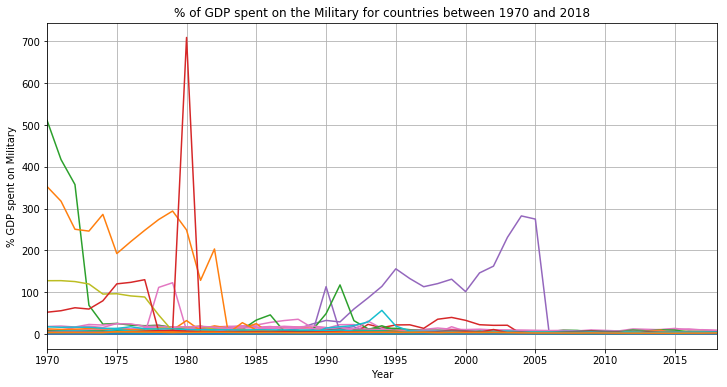

In [151]:
plot_dataframe(df3)

Woah, we have some weird outliers! Who is spending 700% of their GDP on the Military.  Lets find out, this may just be bad data

In [152]:
def get_outliers(df, threshold):
    """Will return a list of countries which spent above a certain threshold"""
    return [col for col in df.columns if df[col].max() > threshold]
        

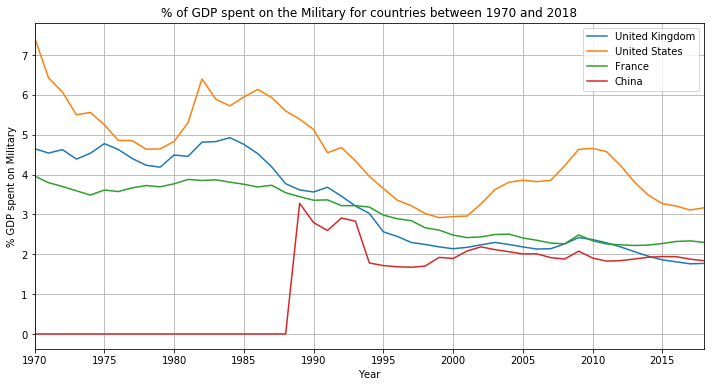

In [165]:
plot_dataframe(df3, ['United Kingdom', 'United States','France','China'], legend=True)

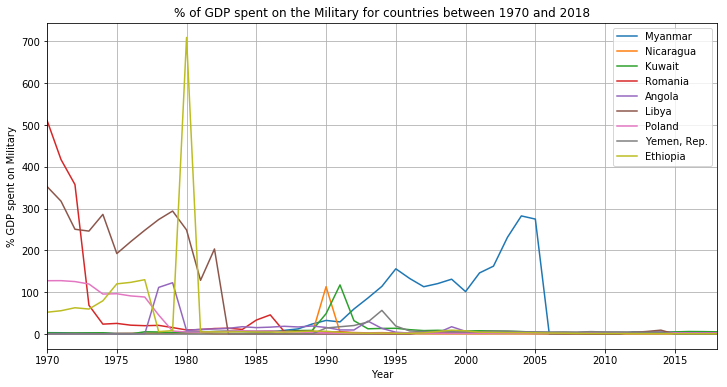

In [153]:
plot_dataframe(df3, get_outliers(df3, 50), legend=True)

Cool! Some of these make some sense, although the scale of the spending seems a bit mad!

Ethiopia -  Lots of coup around the 1970s and a famine / Angola - Civil War in the 1970s / Myanmar - Under military rule until 2008 / Romania - Massive foreign debt grew in the late 1970s.

Lets look at the rest of them...

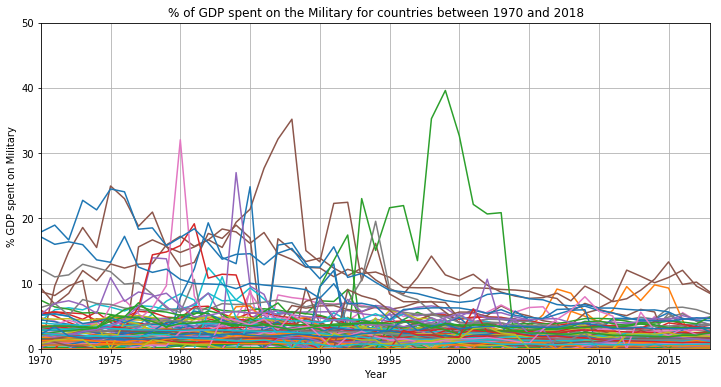

In [157]:
other_countries = [country for country in df3.columns if country not in get_outliers(df3, 50)]
plot_dataframe(df3, other_countries, ylim=50)

Oh dear...I've just noticed there is a Military expenditure (% of GDP) field in the world bank data.  Lets verify our results

In [183]:
df4 = convert_wb_df_to_plottable_time_series_df('Military expenditure (% of GDP)')

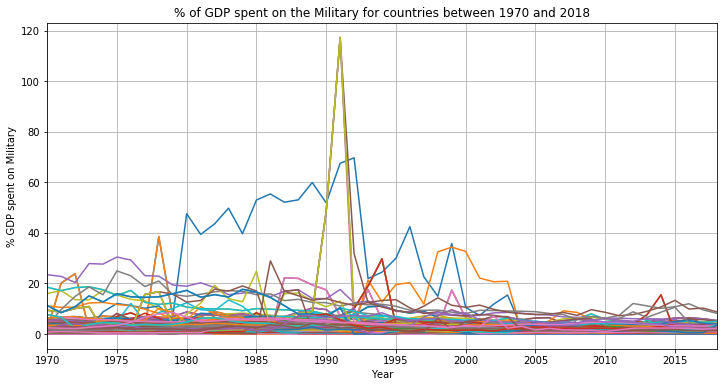

In [213]:
plot_dataframe(df4,)

Looks a bit different. Lets compare Ethiopia data.

Text(0.5, 1.0, 'From World Bank')

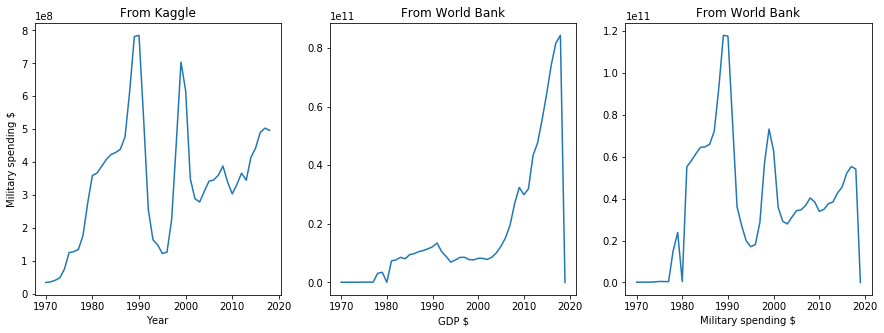

In [219]:
country = 'Ethiopia'
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(df1[country]) # total military spending
ax[1].plot(df2[country]) # total GDP
ax[2].plot(df4[country]*df2[country]) # total military spending, calculated from world bank source
ax[0].set_xlabel('Year') ; ax[1].set_xlabel('Year') ; ax[2].set_xlabel('Year') ;
ax[0].set_ylabel('Military spending $') ; ax[1].set_xlabel('GDP $')
ax[2].set_xlabel('Military spending $') ;
ax[0].set_title('From Kaggle') ; ax[1].set_title('From World Bank')
ax[2].set_title('From World Bank')

The shape is the same between the world bank and kaggle but the scale is very different!  I thought there was something fishy...

### Final thoughts...

Don't believe everything you see, its good to sense check everything.  Think I will drop the kaggle dataset and purely work with the world bank data in another notebook